<a href="https://colab.research.google.com/github/slucasmyer/rl-trading/blob/main/koker_terse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 200

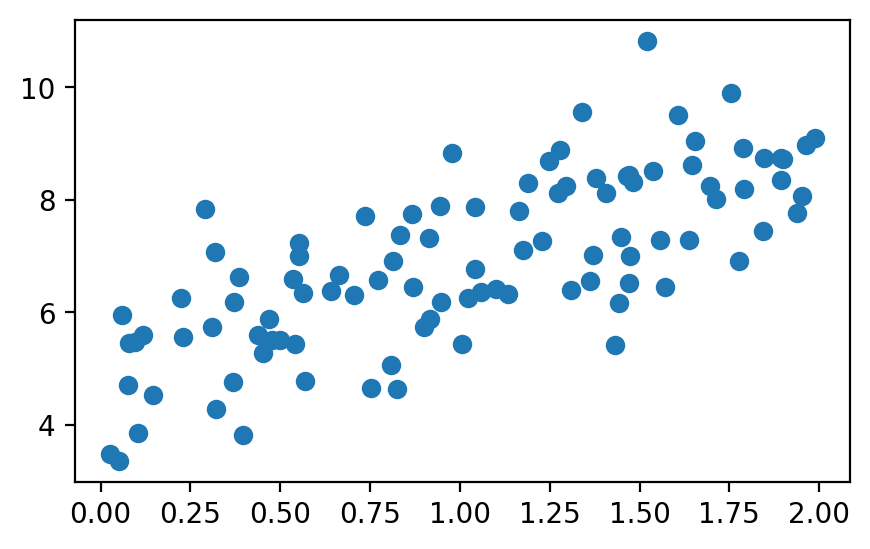

In [2]:
m = 100
x = 2 * np.random.rand(m)
y = 5 + 2 * x + np.random.randn(m)
plt.scatter(x, y);

In [3]:
from scipy.stats import linregress
slope, intercept = linregress(x, y)[:2]
print(f"slope: {slope:.3f}, intercept: {intercept:.3f}")

slope: 1.981, intercept: 4.886


In [4]:
x = np.array([np.ones(m), x]).transpose()
def accuracy(x, y, theta):
    return - 1 / m * np.sum((np.dot(x, theta) - y) ** 2)

In [5]:
def gradient(x, y, theta):
    return -1 / m * x.T.dot(np.dot(x, theta) - y)

In [6]:
num_epochs = 500
learning_rate = 0.1

def train(x, y):
    accs = []
    thetas = []
    theta = np.zeros(2)
    for _ in range(num_epochs):
        # keep track of accuracy and theta over time
        acc = accuracy(x, y, theta)
        thetas.append(theta)
        accs.append(acc)

        # update theta
        theta = theta + learning_rate * gradient(x, y, theta)

    return theta, thetas, accs

theta, thetas, accs = train(x, y)
print(f"slope: {theta[1]:.3f}, intercept: {theta[0]:.3f}")

slope: 1.982, intercept: 4.885


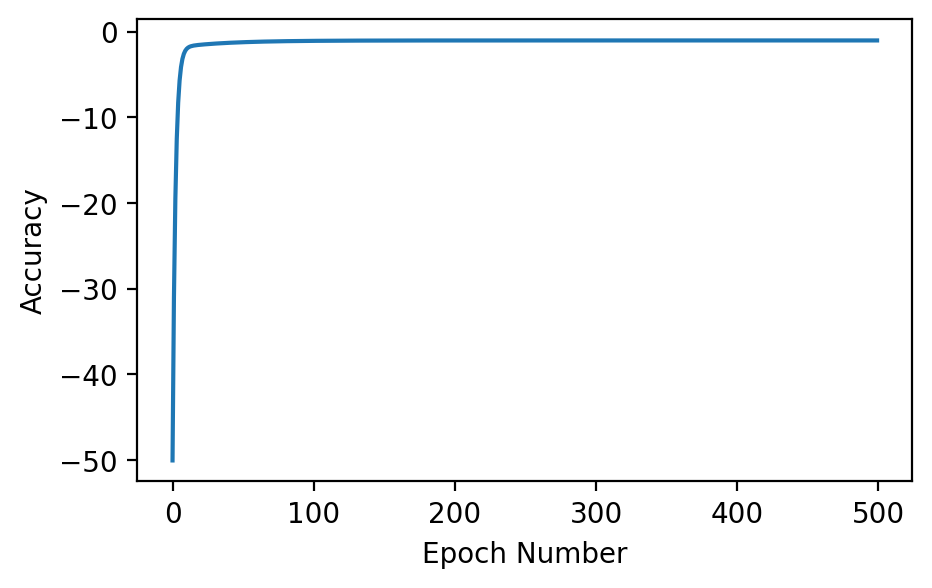

In [7]:
plt.plot(accs)
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy');

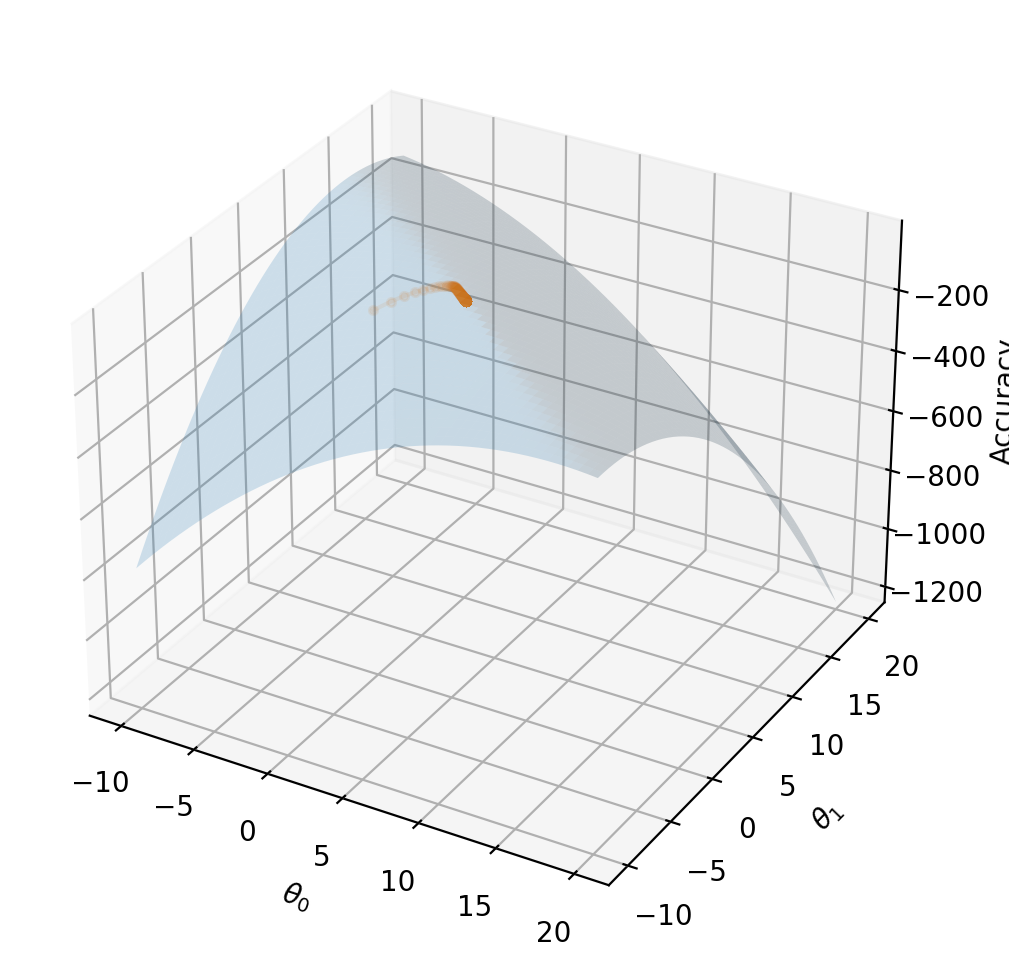

In [9]:
from mpl_toolkits.mplot3d import Axes3D
i = np.linspace(-10, 20, 50)
j = np.linspace(-10, 20, 50)
i, j = np.meshgrid(i, j)
k = np.array([accuracy(x, y, th) for th in zip(np.ravel(i), np.ravel(j))]).reshape(i.shape)
fig = plt.figure(figsize=(9,6))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection = '3d')
ax.plot_surface(i, j, k, alpha=0.2)
ax.plot([t[0] for t in thetas], [t[1] for t in thetas], accs, marker="o", markersize=3, alpha=0.1);
ax.set_xlabel(r'$\theta_0$'); ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel("Accuracy");

In [10]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

In [11]:
import numpy as np

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

In [12]:
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

In [13]:
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2

    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R

    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta

    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta


    return grad, S

In [14]:
def train(x, epochs=2000, M=8, commission=0.0025, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe


    print("finished training")
    return theta, sharpes

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 150
import pandas as pd

btc = pd.read_csv("BTC-USD.csv", names=["date", "price", "volume"]).set_index('date')
btc.index = pd.to_datetime(btc.index, unit='s')
rets = btc['price'].diff()[1:]